Data
A New Cocktail Bar - Improving Bar Scene in Toronto vs New York
The data necessary to answer the problem statement includes the locations and the types of venues around the Toronto city area.

First, the locations of all existing Cocktail Bars  or Bars  in the Toronto city region will be extracted to survey the competition. Ideally, the new Cocktail Bar would be set up at a certain distance away from other existing Bars. Secondly, the locations of travel accommodations such as hotels, hostels and motels in the region will be obtained. This is to estimate the amount of visitors that would frequent the Cocktail Bar, based on the assumption that the clientele of the Cocktail bar would be mainly made up of travellers.

A suitable location for the new Cocktail Bar would be at the centre of a cluster of hotels and hostels so as to maximise the business potential. A clustering algorithm would be performed on the locations of Cocktail Bar and hotels separately to find the concentration of both types of the establishments.

Finally, the ideal location for setting up a new Cocktail Bar can be inferred based on the clustering result.

Create pandas dataframe of Neighborhoods in Toronto
Importing necessary libraries¶

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

Extracting the html file from the URL of postal codes of Canada

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url).text

usaing beautiful soup 

In [4]:
soup = BeautifulSoup(r,'lxml')
btable = soup.find('table')
tab_rows = btable.find_all('tr')

Creating the pandas dataframe and populating it with info from the html
(with processing of Not assigned and duplicate postal code rows)

In [5]:
column_names = ['PostalCode', 'Borough', 'Neighborhood']  # Setting the columns for the new pandas dataframe
postcodes = pd.DataFrame(columns=column_names)

for n in range(1,len(tab_rows)):
    row_t = tab_rows[n].text.split('\n')
    if row_t[2] != 'Not assigned':  # Skip rows with 'Not assigned' Boroughs
        if row_t[3] == 'Not assigned':  # Copying Borough name to 'Not assigned' Neighborhoods
            row_t[3] = row_t[2]
        if row_t[1] in postcodes.loc[:,'PostalCode'].unique():  # Appending the Neighborhood names to duplicate PostalCode areas
            postcodes.loc[tag,'Neighborhood'] = postcodes.loc[tag,'Neighborhood'] + ', ' + row_t[3]
        else: 
            postcodes.loc[n,:] = row_t[1:4]
            tag = n

postcodes.reset_index(drop=True,inplace=True)
postcodes.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [6]:
print('The shape of the dataframe: ',postcodes.shape)

The shape of the dataframe:  (103, 3)


Downloading csv file that has the geographical coordinates of each postal code¶

In [7]:
import csv

!wget -q -O Geospatial_Coordinates.csv http://cocl.us/Geospatial_data
print('Data downloaded!')

# read csv file
coord = pd.read_csv('Geospatial_Coordinates.csv')
coord.head()

Data downloaded!


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Match the Postal Codes to the coordinate values to populate the dataframe

In [10]:
for i,n in enumerate(postcodes['PostalCode']):
    res = coord[coord['Postal Code']==n]
    postcodes.loc[i,'Latitude'] = res.Latitude.values
    postcodes.loc[i,'Longitude'] = res.Longitude.values

postcodes.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


Exploring only neighborhoods in the burough of Central Toronto

In [11]:
central_toronto = postcodes[postcodes['Borough']=='Central Toronto'].reset_index(drop=True)
central_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
3,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
5,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
6,M4S,Central Toronto,Davisville,43.704324,-79.388790
7,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
8,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


2. Search for Cocktail Bars in the neighborhood of Central Toronto

In [12]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
import numpy as np
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.7                |           py36_0         869 KB  conda-forge
    openssl-1.1.1b             |       h14c3975_0         4.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.8 MB

The following packages will be UPDATED:

  conda                                        4.6.4-py36_0 --> 4.6.7-py36_0
  openssl                              1.1.1a-h14c3975_1000 --> 1.1.1b-h14c3975_0



conda-4.6.7          | 869 KB    | ##################################### | 100% 
openssl-1.1.1b       | 4.0 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executi

Define Foursquare credentials and version¶

In [13]:
CLIENT_ID = 'B5HVEXNWNTDSHZB4SA1M5NEUR1WHU0NC15IO5PAJUKXVQROO' # your Foursquare ID
CLIENT_SECRET = 'TLOLVK1L2335Z13MDV2EP1HFAO4B4W24NJBQNCSBYJWQ31VI' # your Foursquare Secret
VERSION = '20181111' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B5HVEXNWNTDSHZB4SA1M5NEUR1WHU0NC15IO5PAJUKXVQROO
CLIENT_SECRET:TLOLVK1L2335Z13MDV2EP1HFAO4B4W24NJBQNCSBYJWQ31VI


Define getNearby Cocktail Bar function for extracting Cocktail Bar venues

In [14]:
def getNearbyBarVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            'Cocktail Bar',
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Select a subset of neighborhoods and explore the nearby Cocktail bars for each

In [15]:
Bar_venues = getNearbyBarVenues(central_toronto['Neighborhood'],central_toronto["Latitude"],central_toronto['Longitude'],2000)
Bar_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.72802,-79.38879,Wildfire Steakhouse & Wine Bar,43.733654,-79.404570,Steakhouse
1,Lawrence Park,43.72802,-79.38879,Istanbul Cafe & Espresso Bar,43.707891,-79.393049,Café
2,Lawrence Park,43.72802,-79.38879,Blo Blow Dry Bar,43.714712,-79.400227,Health & Beauty Service
3,Lawrence Park,43.72802,-79.38879,The Sushi Bar Toronto,43.731613,-79.403873,Japanese Restaurant
4,Lawrence Park,43.72802,-79.38879,Cibo Wine Bar,43.711464,-79.399570,Italian Restaurant


3. Search for hotels, hostels and motels in the neighborhood of Toronto
Define getNearbyHotelVenues function for extracting Hotel venues

In [16]:
def getNearbyHotelVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            'Hostel Hotel',
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
hotel_venues = getNearbyHotelVenues(central_toronto['Neighborhood'],central_toronto["Latitude"],central_toronto['Longitude'],2000)
hotel_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Hotel Wibke,43.707730,-79.395858,Speakeasy
1,Lawrence Park,43.728020,-79.388790,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
2,Lawrence Park,43.728020,-79.388790,Skyline Hotels & Resorts,43.707578,-79.395640,Office
3,Roselawn,43.711695,-79.416936,Hotel Gelato,43.703478,-79.414311,Café
4,Roselawn,43.711695,-79.416936,Hotel Wibke,43.707730,-79.395858,Speakeasy


4. Perform hierarchical clustering on Cocktail Bar and hotel locations in Central Toronto

Generate Folium map (assuming Toronto city hall as the centre of Toronto) to show the locations of Cocktail Bar and hotels

In [19]:
# Assuming Toronto coordinates as 43.653170, -79.383541
tor_latitude = 43.653170
tor_longitude = -79.383541

# create map
map_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(Bar_venues['Venue Latitude'], Bar_venues['Venue Longitude'], Bar_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
    
for lat, lon, poi in zip(hotel_venues['Venue Latitude'], hotel_venues['Venue Longitude'], hotel_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Tabulate coordinates of Cocktail Bar and hotels

In [20]:
Bar_feature = Bar_venues[['Venue Latitude','Venue Longitude']]
hotel_feature = hotel_venues[['Venue Latitude','Venue Longitude']]

Perform hierarchical clustering to group nearby Cocktail Bar and hotels

In [21]:
from sklearn.preprocessing import MinMaxScaler
Bar_data = Bar_feature.values #returns a numpy array
hotel_data = hotel_feature.values
min_max_scaler = MinMaxScaler()
Bar_mtx = min_max_scaler.fit_transform(Bar_data)
hotel_mtx = min_max_scaler.fit_transform(hotel_data)
Bar_mtx [0:5]

array([[0.85396726, 0.37498569],
       [0.58918453, 0.53153575],
       [0.65929056, 0.43400044],
       [0.83298805, 0.38446429],
       [0.6259076 , 0.44292565]])

In [22]:
import scipy
Bar_leng = Bar_mtx.shape[0]
Bar_D = scipy.zeros([Bar_leng,Bar_leng])
for i in range(Bar_leng):
    for j in range(Bar_leng):
        Bar_D[i,j] = scipy.spatial.distance.euclidean(Bar_mtx[i], Bar_mtx[j])
        
print(Bar_D)

[[0.         0.30760009 0.20342507 ... 0.30199393 0.73560178 0.67407536]
 [0.30760009 0.         0.12011658 ... 0.19866143 0.431447   0.38463211]
 [0.20342507 0.12011658 0.         ... 0.14351987 0.53437163 0.47069519]
 ...
 [0.30199393 0.19866143 0.14351987 ... 0.         0.50334273 0.41427118]
 [0.73560178 0.431447   0.53437163 ... 0.50334273 0.         0.11775945]
 [0.67407536 0.38463211 0.47069519 ... 0.41427118 0.11775945 0.        ]]


In [23]:
# Import libraries
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
import pylab
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster

# Perform clustering
Bar_Z = hierarchy.linkage(Bar_D, 'complete')
max_d = 3
Bar_clusters = fcluster(Bar_Z, max_d, criterion='distance')
Bar_dend = hierarchy.dendrogram(Bar_Z)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


In [24]:
hotel_leng = hotel_mtx.shape[0]
hotel_D = scipy.zeros([hotel_leng,hotel_leng])
for i in range(hotel_leng):
    for j in range(hotel_leng):
        hotel_D[i,j] = scipy.spatial.distance.euclidean(hotel_mtx[i], hotel_mtx[j])
        
print(hotel_D)

[[0.         0.11496622 0.00561036 ... 0.66927393 0.71347955 0.70466877]
 [0.11496622 0.         0.11058236 ... 0.6976536  0.70322326 0.7590232 ]
 [0.00561036 0.11058236 0.         ... 0.66664415 0.70935534 0.70337434]
 ...
 [0.66927393 0.6976536  0.66664415 ... 0.         0.23590316 0.17811215]
 [0.71347955 0.70322326 0.70935534 ... 0.23590316 0.         0.41361962]
 [0.70466877 0.7590232  0.70337434 ... 0.17811215 0.41361962 0.        ]]


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


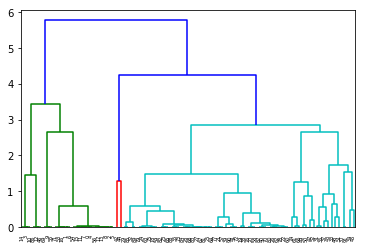

In [25]:
# Perform clustering
hotel_Z = hierarchy.linkage(hotel_D, 'complete')
max_d = 3
hotel_clusters = fcluster(hotel_Z, max_d, criterion='distance')
hotel_dend = hierarchy.dendrogram(hotel_Z)

5. Find suitable location for new Cocktail Bar

In [27]:
Bar_venues['cluster_'] = Bar_clusters
hotel_venues['cluster_'] = hotel_clusters

Generate a Folium map to illustrate the clusters of Cocktail Bar and hotels (reds: Cocktail Bar, blues: Hotels)

In [28]:
# Assuming Toronto coordinates as 43.653170, -79.383541
tor_latitude = 43.653170
tor_longitude = -79.383541

# create map
map_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=12)

# set color scheme for the laundromat clusters
Bar_kclusters = Bar_clusters.max()
x = np.arange(Bar_kclusters)
ys = [i+x+(i*x)**2 for i in range(Bar_kclusters)]
colors_array = cm.rainbow(np.linspace(0.8, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Bar_venues['Venue Latitude'], Bar_venues['Venue Longitude'], Bar_venues['Venue'], Bar_venues['cluster_']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# set color scheme for the hotel clusters
hotel_kclusters = hotel_clusters.max()
x = np.arange(hotel_kclusters)
ys = [i+x+(i*x)**2 for i in range(hotel_kclusters)]
colors_array = cm.rainbow(np.linspace(0.1, 0.3, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotel_venues['Venue Latitude'], hotel_venues['Venue Longitude'], hotel_venues['Venue'], hotel_venues['cluster_']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Extracting the coordinate of cluster centers for better visualisation of Cocktail Bar and hotel hotspots around Central Toronto

In [30]:
Bar_mean = pd.DataFrame(columns=['Venue Latitude','Venue Longitude'])
Bar_count = pd.DataFrame(columns=['Number of Venues'])
hotel_mean = pd.DataFrame(columns=['Venue Latitude','Venue Longitude'])
hotel_count = pd.DataFrame(columns=['Number of Venues'])

for i in range(1,Bar_kclusters+1):
    Bar_mean.loc[i-1,:]=Bar_venues[Bar_venues['cluster_']==i][['Venue Latitude','Venue Longitude']].mean()
    Bar_count.loc[i-1] = Bar_venues[Bar_venues['cluster_']==i]['cluster_'].count()

for i in range(1,hotel_kclusters+1):
    hotel_mean.loc[i-1,:]=hotel_venues[hotel_venues['cluster_']==i][['Venue Latitude','Venue Longitude']].mean()
    hotel_count.loc[i-1] = hotel_venues[hotel_venues['cluster_']==i]['cluster_'].count()
    
Bar_mean = pd.concat([Bar_mean, Bar_count], axis=1, sort=False)
hotel_mean = pd.concat([hotel_mean, hotel_count], axis=1, sort=False)
print('Cocktail Bar clusters: \n',Bar_mean)
print('Hotel clusters: \n',hotel_mean)

Cocktail Bar clusters: 
    Venue Latitude Venue Longitude Number of Venues
0         43.7119        -79.4007               69
1         43.7053        -79.3961              127
2         43.6866        -79.3936               42
3         43.7068        -79.3754               10
4         43.6984         -79.416               21
5         43.7317        -79.4064               26
6         43.7249        -79.4312                3
7         43.7424        -79.3743                2
8          43.665        -79.3834               12
9         43.6707        -79.3913               53
10        43.6697        -79.4056               22
11        43.6764        -79.3587                2
12        43.6573        -79.4107                8
Hotel clusters: 
   Venue Latitude Venue Longitude Number of Venues
0        43.6959        -79.4155                6
1        43.7075        -79.3911               20
2         43.656        -79.4106                2
3         43.668        -79.3916           

Generating Folium map with showing Cocktail Bar and hotel clusters, with larger circles representing a higher concentration of venues
(Reds: Cocktail Bar, Blues: Hotels)

In [32]:
# Assuming Toronto coordinates as 43.653170, -79.383541
tor_latitude = 43.653170
tor_longitude = -79.383541

# create map
map_center_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=12)

# set color scheme for the laundromat clusters
Bar_kclusters = Bar_clusters.max()
x = np.arange(Bar_kclusters)
ys = [i+x+(i*x)**2 for i in range(Bar_kclusters)]
colors_array = cm.rainbow(np.linspace(0.8, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
scale_Bar = Bar_mean['Number of Venues'].max()
for lat, lon, clustsize, clustnum in zip(Bar_mean['Venue Latitude'], Bar_mean['Venue Longitude'], Bar_mean['Number of Venues'],Bar_mean.index):
    label = folium.Popup(' Cocktail Bar Cluster ' + str(clustnum+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=clustsize/scale_Bar*30,
        popup=label,
        color=rainbow[clustnum],
        fill=True,
        fill_color=rainbow[clustnum],
        fill_opacity=0.7).add_to(map_center_clusters)
# set color scheme for the hotel clusters
hotel_kclusters = hotel_clusters.max()
x = np.arange(hotel_kclusters)
ys = [i+x+(i*x)**2 for i in range(hotel_kclusters)]
colors_array = cm.rainbow(np.linspace(0.1, 0.3, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
scale_hotel = hotel_mean['Number of Venues'].max()
for lat, lon, clustsize, clustnum in zip(hotel_mean['Venue Latitude'], hotel_mean['Venue Longitude'], hotel_mean['Number of Venues'], hotel_mean.index):
    label = folium.Popup(' Hotel Cluster ' + str(clustnum+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=clustsize/scale_hotel*30,
        popup=label,
        color=rainbow[clustnum],
        fill=True,
        fill_color=rainbow[clustnum],
        fill_opacity=0.7).add_to(map_center_clusters)
       
map_center_clusters  